## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
df

review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Petter Mattei's "Love in the Time of Money" is...  positive
4      Probably my all-time favorite movie, a story o...  positive
...                                                  ...       ...
24694  I have seen this movie at the cinema many year...  negative
24695  This movie was a real torture fest to sit thro...  negative
24696  John Wayne & Albert Dekker compete for oil rig...  negative
24697  Tarantino once remarked on a melodrama from th...  positive
24698  Aah yes the workout show was a great. Not only...  positive

[24699 rows x 2 columns]

## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

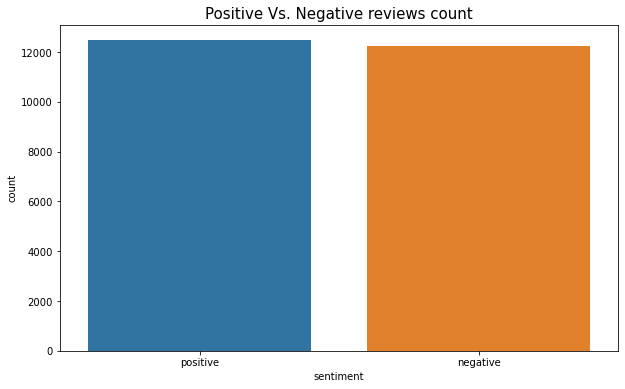

In [4]:
plt.figure(figsize = (10,6))# size is 10,6
sns.countplot(x="sentiment", data=df)#use countplot to plot the amount of positive and the amount of negative
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [5]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df.sentiment=="positive"]# get data about sentiment is positive, and the amount of positive is more than that of negative
df_minority = df[df.sentiment=="negative"]# get data about sentiment is negative, and the amount of positive is more than that of negative

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)# return all rows (in random order)

In [6]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df.sentiment=="negative"].shape#print the shape of data about negative

(12474, 2)

### Expected Output : 
(12474, 2)

In [7]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df.sentiment=="positive"].shape#print the shape of data about negative

(12474, 2)

### Expected Output : 
(12474, 2)

In [8]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df.sentiment=="negative"].iloc[:10000]#when sentiment is negative, select first ten thousand rows
positive_data_points_train = df_upsampled[df.sentiment=="positive"].iloc[:10000]#when sentiment is positive, select first ten thousand rows

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df.sentiment=="negative"].iloc[10000:]#when sentiment is negative, select the data after 10000
positive_data_points_test = df_upsampled[df.sentiment=="positive"].iloc[10000:]#when sentiment is positive, select the data after 10000

## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train['review'], positive_data_points_train['review']])#concat the reviews of two data which are negative_data_points_train and positive_data_points_train 
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train['sentiment'], positive_data_points_train['sentiment']])#concat the sentiment of two data which are negative_data_points_train and positive_data_points_train

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test['review'], positive_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test['sentiment'], positive_data_points_test['sentiment']])


In [9]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [10]:
y_test.value_counts()

negative    2474
positive    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [11]:
import nltk
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
ps = nltk.PorterStemmer()#stemming

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\54364\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
def toLowerCase(text):
    return text.lower() #changes all upper case alphabet to lower case
import string
string.punctuation # checking punctuations
def removePunctuation(text):
    return "".join([char for char in text if char not in string.punctuation])#removePunctuation

In [13]:
import re
def removeURLs(text):
    
    text = re.sub(r"http\S+", "", text) # replaces URLs starting with http 
    text = re.sub(r"www.\S+", "", text) # replaces URLs starting with wwe
    return text

In [14]:
# TASK CELL
from nltk.tokenize import sent_tokenize, word_tokenize# Use NLTK Pakecage to import sent_tokenize and word_tokenize
from nltk.corpus import stopwords# Use NLTK Pakecage to import stopwords
nltk.download('stopwords')
def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    text1 = toLowerCase(review)#toLowerCase
    text2 = removeURLs(text1)#removeURLs
    text = removePunctuation(text2)#removePunctuation
    
    
    
    words = text.split()#split str 
    r = []#store final result
    for w in words:
        if w not in stopwords.words("english"):#select words which are not in stopword.word
            r.append(ps.stem(w))#stemming
    review_cleaned=' '.join(r)#combine str
    


    return review_cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\54364\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [15]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    if frequency[(word,label)] in frequency.keys():
        n = frequency[(word,label)]#frequency give n the frequency of special pair
    else:
        n = 0# if (word,label) is not in frequency.keys(), give n 0
  
    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [16]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [17]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [18]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'Now don\'t get me wrong, I love seeing half naked chicks wiggling around. It\'s part of the fun of a Moroccan restaurant: ogling the belly dancers. But it doesn\'t make much of a plot.<br /><br />My first major problem is the music. I have the feeling that when Ann Rice wrote "The Vampire Lestat", the Cure was more the style of the music he would have liked (though I could be wrong). I know relating to current "goth" music might have seemed like a good idea, but they did a horrific job incorporating it. Lestat was an actor with presumably a pretty good singing voice. That they chose Jonathan Davis to be his stage voice is heartbreaking.<br /><br />Second, and someone else said it, mashing two very intricate books into one crappy movie is a bad idea. "Lestat" could have been a movie in it\'s own right, and a damn good one if done right. I honestly don\'t think "Queen of the Damned" lends itself to a movie very well. Though I would love to see a movie that incorporates a creation story,

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [19]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

dont get wrong love see half nake chick wiggl around part fun moroccan restaur ogl belli dancer doesnt make much plotbr br first major problem music feel ann rice wrote vampir lestat cure style music would like though could wrong know relat current goth music might seem like good idea horrif job incorpor lestat actor presum pretti good sing voic chose jonathan davi stage voic heartbreakingbr br second someon els said mash two intric book one crappi movi bad idea lestat could movi right damn good one done right honestli dont think queen damn lend movi well though would love see movi incorpor creation stori there much word inact book interest movi retel soil pretti badli mind long time sinc ive read alway thought lestat tale bodi thief memnoch devil much action pack would made better moviesbr br know lot peopl hey includ like lot cheesi vampir crap thought absolut worst genr major motion pictur tend agre aaliyah nice bodi though


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [20]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
        split_review = clean_review(review).split()#clean review(delete stopwords)and split cleaned review
        for word in split_review:
            thisword = (word,label)# make temporary key
            if thisword in output_occurrence.keys():#if temporary key in output_occurrence
                output_occurrence[thisword] += 1# value add 1
            else:
                output_occurrence[thisword] = 1#if not, add this temporary key in output_occurrence, initial value is 1    
        # Your code here
   
    return output_occurrence
   


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [21]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [22]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [23]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('dont', 1): 4184,
 ('get', 1): 5994,
 ('wrong', 1): 911,
 ('love', 1): 2206,
 ('see', 1): 5060,
 ('half', 1): 954,
 ('nake', 1): 231,
 ('chick', 1): 205,
 ('wiggl', 1): 6,
 ('around', 1): 1458,
 ('part', 1): 2002,
 ('fun', 1): 810,
 ('moroccan', 1): 3,
 ('restaur', 1): 67,
 ('ogl', 1): 6,
 ('belli', 1): 32,
 ('dancer', 1): 90,
 ('doesnt', 1): 1997,
 ('make', 1): 6195,
 ('much', 1): 3879,
 ('plotbr', 1): 63,
 ('br', 1): 23759,
 ('first', 1): 3264,
 ('major', 1): 465,
 ('problem', 1): 1056,
 ('music', 1): 1179,
 ('feel', 1): 1974,
 ('ann', 1): 201,
 ('rice', 1): 29,
 ('wrote', 1): 294,
 ('vampir', 1): 355,
 ('lestat', 1): 18,
 ('cure', 1): 62,
 ('style', 1): 521,
 ('would', 1): 5727,
 ('like', 1): 9568,
 ('though', 1): 1629,
 ('could', 1): 3625,
 ('know', 1): 3131,
 ('relat', 1): 235,
 ('current', 1): 115,
 ('goth', 1): 23,
 ('might', 1): 1287,
 ('seem', 1): 3298,
 ('good', 1): 5821,
 ('idea', 1): 1338,
 ('horrif', 1): 67,
 ('job', 1): 633,
 ('incorpor', 1): 22,
 ('actor', 1): 2760,
 (

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [24]:
import math# for calculate

In [25]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
#     vocab = list(freqs.keys())
#     V = len(vocab)
    x=list(freqs.keys())#transfer keys into list
    zanshi = []#store unique words from freq's keys
    for i in range(len(x)):#x is list freq's keys
        if x[i][0] not in zanshi:
            zanshi.append(x[i][0])# add words if it doesn't appear in list zanshi
    vocab = zanshi
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] == 0:
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(X_train)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = 0#initial value
    for u in train_y:
        if u == 0:#0 represent positive
            pos_num_docs += 1
            

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = 0
    for u in train_y:
        if u == 1:#1 represent negative
            neg_num_docs += 1

    # Calculate logprior
    logprior = math.log(neg_num_docs)-math.log(pos_num_docs)#equation 3


    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        if (word,0)in freqs.keys():#if this word,0 in freq, freq_pos will get value from freqs. If not, freq_pos get 0
            freq_pos = freqs[word,0]
        else:
            freq_pos = 0
        if (word,1)in freqs.keys():#if this word,1 in freq, freq_pos will get value from freqs. If not, freq_pos get 0
            freq_neg = freqs[word,1]
        else:
            freq_neg = 0


        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(pos_num_docs+V)
        p_w_neg = (freq_neg+1)/(V+neg_num_docs)

        # calculate the log likelihood of the word
        loglikelihood[word] = math.log((p_w_neg/p_w_pos))#equation 6



    return logprior, loglikelihood

In [26]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
75711


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [27]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
      # process the review to get a list of words
    word_l = clean_review(review).split()# clean review, then split it

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = logprior# this parameter from train_naive_bayes

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood.keys():
            # add the log likelihood of that word to the probability
            total_prob = total_prob + loglikelihood[word]
    if total_prob >0:# the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0.
        re = 1
    else:
        re=0


    return re

In [28]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [126]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review)>0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append[y_hat_i]

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = 0# calculate error which means fp + fn
    for ii in range(len(test_y)):
        if y_hats[ii] != test_y[ii]:
            error += 1
            

    accuracy = (len(y_hats)-error)/len(test_y)#(tp+tn)/(tp+fp+tn+fn)


    return accuracy

In [29]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [30]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [129]:
from sklearn.model_selection import train_test_split#use sklearn's train_test_split to randomly select train and test data

train, test = train_test_split(df, test_size=0.2, random_state=42)#80% of this data become train data and 20% of this data become test data,set random seed 42
reviews_train = train['review']#split review 
senti_train = train['sentiment']#split sentiment
reviews_test = test['review']#split review
senti_test = test['sentiment']#split sentiment

In [130]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 
output_map = {'positive': 0, 'negative': 1}
senti_train = senti_train.map(output_map)
senti_test = senti_test.map(output_map)

In [131]:
freqs = review_counter({}, reviews_train, senti_train)# Build the freqs dictionary for later uses

In [132]:
logprior, loglikelihood = train_naive_bayes(freqs, reviews_train , senti_train)#return parameters which are logprior, loglikelihood

In [133]:
train_predict_result = []#store predict result of train data
for r in reviews_train:
    p = naive_bayes_predict(r, logprior, loglikelihood)#return predict single result of train data
    train_predict_result.append(p)

In [134]:
from sklearn.metrics import confusion_matrix
confusion_matrix(senti_train, train_predict_result)#use skelearn to do confusion matrix

array([[9444,  559],
       [1117, 8639]], dtype=int64)

In [141]:
(9444+8639)/(9444+8639+1117+559)#calculate accuracy of train data

0.9151778936180981

In [136]:
test_predict_result = []#store predict result of test data
for rr in reviews_test:
    p = naive_bayes_predict(rr, logprior, loglikelihood)#return predict single result of test data
    test_predict_result.append(p)

In [137]:
confusion_matrix(list(senti_test), test_predict_result)#use skelearn to do confusion matrix

array([[2255,  216],
       [ 509, 1960]], dtype=int64)

In [142]:
(2255+1960)/(2255+1960+509+216)#calculate accuracy of test data

0.8532388663967612

# 4.From confusion matrix, we know test confusion matrix has 509 FN and 216 FP. And Train confusion matrix has 1117 FN and 559 FP.  There are some words. When they come to movie reviews, there are times when certain words are used in a different sentiment than their global sentiment. For examplea word like 'Fantastic' has a positive global sentiment, however. when sarcasm is involved the sentiment of the word changes. Since, we are using Bag of Words method for our first assignment, it is a comparatively naive approach. This could explain the presence of FP and FN in our output.

# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [139]:
loglikelihood['logprior'] = logprior# add the vaule of logprior into loglikelihood for store the value of logprior 
import csv
f = open('parameter2.csv', mode='a',encoding='utf-8',newline='')
csv_writer= csv.DictWriter(f,fieldnames=list(loglikelihood.keys()))# add head of cvs
csv_writer.writeheader()# add head of cvs
csv_writer.writerow(loglikelihood)#add value

1622357

In [140]:
#upload parameter
para = pd.read_csv("parameter2.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

#1.naive Bayes naively multiplies all the feature likelihoods together, zero probabilities in the likelihood term for any class will cause the probability of theclass to be zero, no matter the other evidence!
for example: Training:
   - just plain boring -
   - entirely predictable and lacks energy -
   - no surprises and very few laughs -
   + no very powerful +
   + the most fun film of the summer +


P(−) = 3/5
P(+) = 2/5
if our test is "predictable with no fun"
P(“predictable”|−) = 1/14+20
P(“predictable”|+) = 0/9+20
P(“no”|−) = 1/14+20
P(“no”|+) = 1/9+20
P(“fun”|−) = 1/14+20
P(“fun”|+) = 1/9+20
So P(−)P(S|−) = 0, P(+)P(S|+)=0, there are + doesn't have 'predictable' and - doesn't have 'fun', we conclude that "predictable with no fun" probability is 0 in + and -. This is a bad outcome

#2(a) computers can be rather limited when representing very small numbers and (b) logs have the wonderful ability to turn multiplication into addition, and computers are much faster at addition.